In [0]:
import scipy.io as sci
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm 
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling2D, Conv2D, MaxPool1D, Dropout
from keras import optimizers
from keras.utils import to_categorical
from google.colab import drive

In [311]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [312]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
mat = sci.loadmat('./assets/Indian_pines.mat')
mat_corr = sci.loadmat("./assets/Indian_pines_corrected.mat")
matGt = sci.loadmat('./assets/Indian_pines_gt.mat')

In [0]:
ip = mat['indian_pines']
ip_corr = mat_corr['indian_pines_corrected']

In [0]:
def fnormReduction(dataset,threshold):
    '''
    Takes dataset as input, plots the Square of Fnorm vs band, and rejects bands with square of F-norm less than the threshold.
    Returns the new dataset of the format --> (number of samples,dimension of each sample).
    '''
    fnormSq_corr = []
    lim = dataset.shape[2]
    band_corr = [x for x in range(0,lim)]
    thresholdedDataset = []
    
    for i in tqdm(range(0,lim)):
        pic = dataset[:,:,i]
        tempVal = np.multiply(pic,pic)
        sqfnorm = np.sum(tempVal)
        if sqfnorm>threshold:
            thresholdedDataset.append(pic)
        fnormSq_corr.append(sqfnorm)
    
    color = ['r','g','b']
    randomColor = np.random.randint(0,len(color))
    plt.figure(figsize=(20,8))
    plt.plot(band_corr,fnormSq_corr,color[randomColor])
    plt.show()
    
    return(np.array(thresholdedDataset))

In [0]:
def scaler(nparr):
    '''
    Scales and normalizes the numpy array
    '''
    return ((nparr-np.mean(nparr))/np.std(nparr))

In [0]:
def flatten(dataset):
    '''
    flattens and returns the 'dataset' for better analysis.
    Output - numpy array --> (no. of samples, flattened feature numpy array)
    
    '''
    lim = dataset.shape[0]
    dim1 = dataset.shape[1]
    dim2 = dataset.shape[2]
    scaledArr = []
    
    for i in range(0,lim):
        arr = dataset[i,:,:]
        scaled = scaler(arr)
        scaled = np.array(scaled)
        scaled = scaled.ravel()
        scaledArr.append(scaled)
    
    return(np.array(scaledArr))

100%|██████████| 200/200 [00:00<00:00, 16372.49it/s]


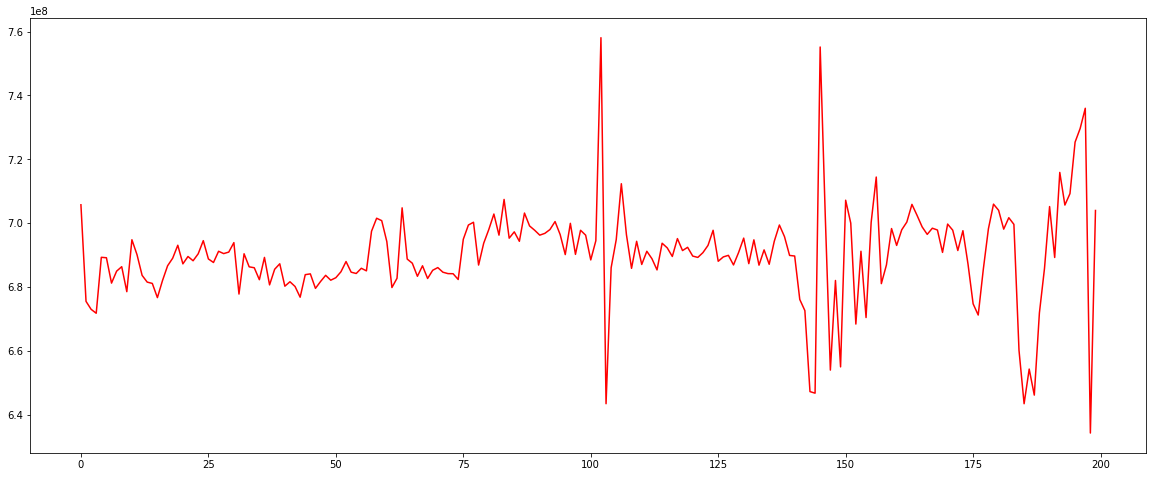

In [318]:
ip_threshold = fnormReduction(ip_corr,6.7e8) #for now threshold = ,previous = 6.855e8

In [0]:
ip_threshold = scaler(ip_threshold) #scaled the thresholded dataset 

In [320]:
ip_threshold.shape

(189, 145, 145)

In [0]:
numberOfBands = ip_threshold.shape[0]

In [322]:
type(ip_threshold[1,:,:])

numpy.ndarray

In [0]:
ip_scaled = flatten(ip_threshold) #flattening the thresholded dataset

In [324]:
ip_scaled.shape

(189, 21025)

In [325]:
ip_scaled[1,:].shape #shape of sample no. 1 in the scaled and flattened numpy array

(21025,)

In [0]:
def plotBand(dataset,band):
    print("Band No.: ",band)
    plt.figure(figsize=(8,8))
    plt.imshow(dataset[band,:].reshape(145,145),cmap='terrain')
    plt.colorbar()
    plt.show()

Band No.:  121


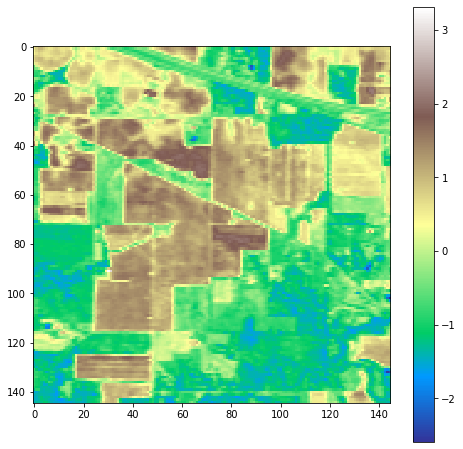

In [327]:
plotBand(ip_scaled,band=121) #for now band no. = 121 is plotted

In [0]:
def pcaReduction(dataset,components):
    '''Applies PCA reduction on the dataset and transforms it into param:'components' number of axes
    '''
    pca = PCA(n_components=components)
    principalComp = pca.fit_transform(dataset)
    return principalComp

In [0]:
pcaArr = ip_scaled.T

In [0]:
pc = 15

In [0]:
principalComponents = pcaReduction(pcaArr,pc) #number of PCs for now = 15

In [332]:
type(principalComponents)

numpy.ndarray

In [333]:
principalComponents.shape

(21025, 15)

In [0]:
spatialMatrixPrecursor = np.reshape(principalComponents,(145,145,pc))

In [335]:
spatialMatrixPrecursor.shape

(145, 145, 15)

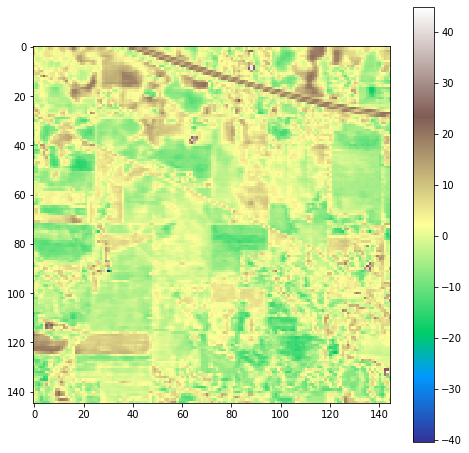

In [336]:
plt.figure(figsize=(8,8))
plt.imshow(spatialMatrixPrecursor[:,:,1],cmap='terrain')
plt.colorbar()
plt.show()

In [337]:
ip_scaled.shape

(189, 21025)

In [338]:
ip_threshold.shape

(189, 145, 145)

In [0]:
paddedPrecursor = np.zeros((145+2,145+2,pc))

In [340]:
for i in tqdm(range(0,pc)):
    paddedPrecursor[1:146,1:146,i] = spatialMatrixPrecursor[:,:,i]

100%|██████████| 15/15 [00:00<00:00, 3655.06it/s]


In [0]:
paddedThreshold = np.zeros((numberOfBands,145+2,145+2))

In [342]:
for i in tqdm(range(0,numberOfBands)):
    paddedThreshold[i,1:146,1:146] = ip_threshold[i,:,:]

100%|██████████| 189/189 [00:00<00:00, 13408.27it/s]


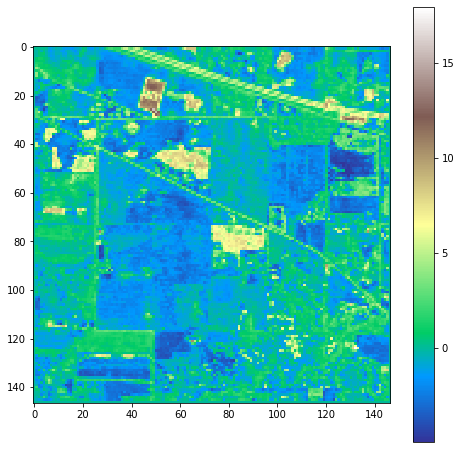

In [343]:
plt.figure(figsize=(8,8))
plt.imshow(paddedPrecursor[:,:,2],cmap='terrain')
plt.colorbar()
plt.show()

In [344]:
paddedPrecursor.shape

(147, 147, 15)

In [0]:
#Creation of 3*3*pc pixel boxes for spatial characteristics

In [0]:
def flattenedVector(pixel,box):
    '''
    Returns flattened vector consisting of both spectral as well as spatial charateristics
    '''
    r = pixel[0]
    c = pixel[1]
    val = box.shape[0]*box.shape[1]*box.shape[2]
    spectralInfo = paddedThreshold[:,r,c]
    spectralInfo = np.reshape(spectralInfo,(numberOfBands,1))
    spatialInfo = np.ravel(box)
    spatialInfo = np.reshape(spatialInfo,(val,1))
    inputVector = []
    for i in spectralInfo:
        inputVector.append(i)
    for j in spatialInfo:
        inputVector.append(j)
    inputVector = np.array(inputVector)
    #print(inputVector.shape)
    
    return inputVector
    

In [0]:
def boxing():
    pixelAndValue = np.zeros((145*145,18,18))
    var = np.zeros((145,145,324))
    inputVectorCnn = []
    count = 0
    #inputVectorCnnRow = []
    for i in tqdm(range(1,146)):
        for j in range(1,146):
            box = paddedPrecursor[i-1:i+2,j-1:j+2,:]
            vec = flattenedVector([i,j],box)
            
            img = np.reshape(vec,(18,18))
            pixelAndValue[count,:,:] = img
            count+=1
           # pixelAndValue.append([i-1,j-1,vec])
            for k in range(324):
                var[i-1][j-1][k] = vec[k]
            
            
            #inputVectorCnn.append(vec)
        #inputVectorCnn.append(inputVectorCnnRow)
    
    #inputVectorCnn = np.array(inputVectorCnn)
   # print(inputVectorCnn.shape)
    #return(inputVectorCnn)
    print('count = ',count)
    return [pixelAndValue,var]

In [348]:
xinp,inputVectorList = boxing()
#inputVectorList is a 3-D numpy arrays of the format --> (145,145,256)

100%|██████████| 145/145 [00:09<00:00, 14.65it/s]

count =  21025


In [349]:
inputVectorList.shape

(145, 145, 324)

In [0]:
ipgt = matGt['indian_pines_gt']

In [351]:
ipgt.shape

(145, 145)

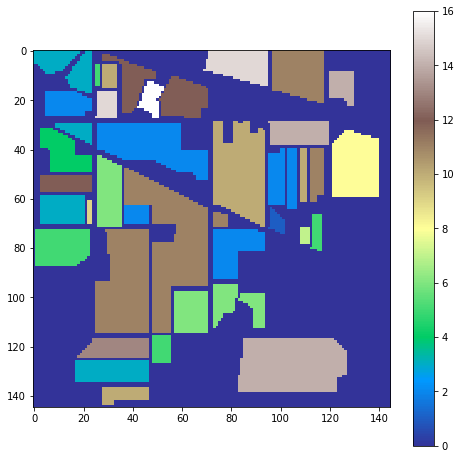

In [352]:
plt.figure(figsize=(8,8))
plt.imshow(ipgt,cmap='terrain')
plt.colorbar()
plt.show()

In [0]:
y = to_categorical(ipgt)

In [354]:
y.shape

(145, 145, 17)

In [355]:
y[0][0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [0]:
depth = inputVectorList.shape[2]

In [357]:
depth

324

In [358]:
xinp.shape

(21025, 18, 18)

In [0]:
Xtrain = xinp

In [360]:
Xtrain.shape

(21025, 18, 18)

In [361]:
y.shape

(145, 145, 17)

In [362]:
ipgt

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [363]:
ipgt.shape

(145, 145)

In [0]:
ipgt_corr = np.reshape(ipgt,(145*145,1))

In [0]:
ytr = to_categorical(ipgt_corr)

In [366]:
ytr.shape

(21025, 17)

In [0]:
Y_train = ytr
Xtrain = scaler(Xtrain)
X_train = np.zeros((21025,18,18,1))

In [0]:
X_train[:,:,:,0] = Xtrain

In [0]:
model = Sequential()
model.add(Conv2D(16, kernel_size=5, activation='sigmoid', input_shape=(18,18,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.5))
model.add(Conv2D(32, kernel_size=4, activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation = 'sigmoid'))
#model.add(Dropout(0.5))
model.add(Dense(17, activation='softmax'))

In [0]:
sgd = optimizers.SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=True)

adam = optimizers.Adam(lr=1)
rmsprop = optimizers.RMSprop(lr=1)
adagrad = optimizers.Adagrad(lr=1)


In [0]:
model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['accuracy']) #huber_loss, squared_hinge, categorical_crossentropy

In [372]:
history = model.fit(X_train, Y_train, epochs=100,verbose=1)

Epoch 1/100
21025/21025 [==============================] - 4s 174us/step - loss: 0.0387 - acc: 0.5404
Epoch 2/100
21025/21025 [==============================] - 3s 156us/step - loss: 0.0336 - acc: 0.5852
Epoch 3/100
21025/21025 [==============================] - 3s 154us/step - loss: 0.0319 - acc: 0.5974
Epoch 4/100
21025/21025 [==============================] - 3s 156us/step - loss: 0.0303 - acc: 0.6156
Epoch 5/100
21025/21025 [==============================] - 3s 155us/step - loss: 0.0289 - acc: 0.6425
Epoch 6/100
21025/21025 [==============================] - 3s 154us/step - loss: 0.0305 - acc: 0.6154
Epoch 7/100
21025/21025 [==============================] - 3s 153us/step - loss: 0.0266 - acc: 0.6729
Epoch 8/100
21025/21025 [==============================] - 3s 156us/step - loss: 0.0250 - acc: 0.6932
Epoch 9/100
21025/21025 [==============================] - 3s 155us/step - loss: 0.0252 - acc: 0.6923
Epoch 10/100
21025/21025 [==============================] - 3s 153us/step - loss: 

In [373]:
model.evaluate(X_train,Y_train)

21025/21025 [==============================] - 1s 70us/step


[0.006550809233352007, 0.9300356718192628]

In [374]:
model.metrics_names

['loss', 'acc']

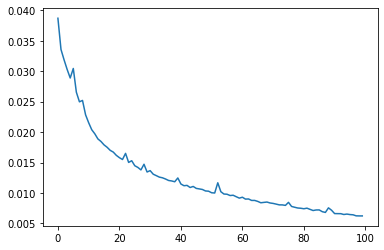

In [375]:
plt.plot(history.history['loss'])

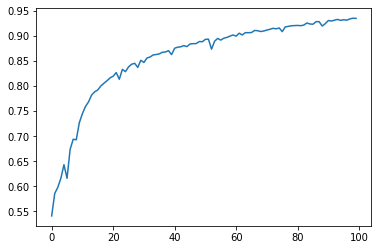

In [376]:
plt.plot(history.history['acc'])

In [377]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 16)        416       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 32)          8224      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_8 (Dense)              (None, 17)               